# What's an autoencoder?

An autoencoder is a type of neural network used to learn efficient encoding of input data. This is primarily done to reduce dimensionality.

Specifically, they are unsupervised Artifical Neural Networks (ANNs), aimed at learning representations (encoding) of the input data to capture essential features and reduce the dimensionality of the data. This encoding is then used to reconstruct the original input, as closely as possible.

Dimensionality is reduced because **sample density** decreases as dimensions increase. As more features are added without an increase in the number of training samples, the 'density' of the data decreases and overfitting becomes much more likely.

Autoencoders have two key components: 
* Encoder:
    - Compresses the input data into a 'latent-space representation'.
* Decoder:
    - Reconstructs the original input from the representation.

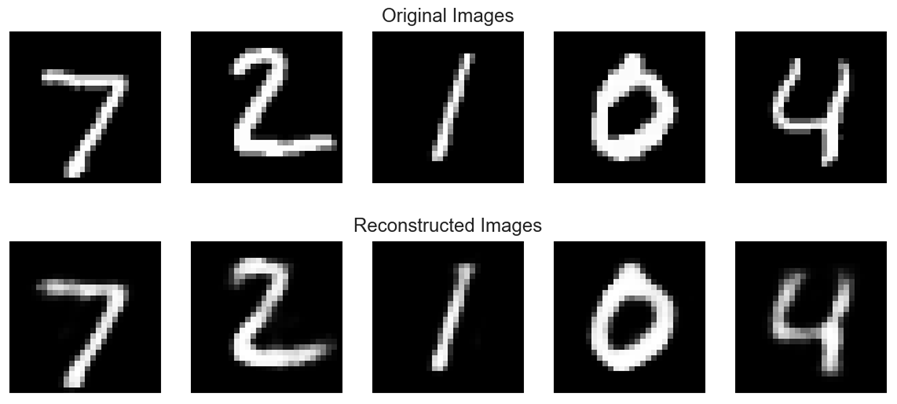

The images are visibly a bit lower quality, however the essential features of each number remain; therefore, the amount of pixels (dimensions) has reduced, but you can still clearly identify each number here.

Autoencoders can also be used for more than just dimensionality reduction; they can also be used to do things like colour black and white images and reduce noise from images.

# Implementation

## Setup

### Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.optimizers import Adam
warnings.filterwarnings('ignore')

### Loading and prepping data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and flatten images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))
print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (60000, 784)
Test shape: (10000, 784)


### Visualisation function definitions

You can probably use these or something similar in the assignment.

In [5]:
def plot_autoencoder_outputs(autoencoder, n=5, dims=(28, 28)):
    decoded_imgs = autoencoder.predict(x_test)
    plt.figure(figsize=(10, 4.5))
    
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims), cmap='gray')
        ax.axis('off')
            
        if i == n // 2:
            ax.set_title('Original Images')

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims), cmap='gray')
        ax.axis('off')
        
        if i == n // 2:
            ax.set_title('Reconstructed Images')

    plt.tight_layout()
    plt.show()

def compare_autoencoder_outputs(encoder1, encoder2, n=5, dims=(28, 28)):
    encoder1images = encoder1.predict(x_test)
    encoder2images = encoder2.predict(x_test)
    plt.figure(figsize=(10, 4.5))
    
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(encoder1images[i].reshape(*dims), cmap='gray')
        ax.axis('off')
            
        if i == n // 2:
            ax.set_title('Encoder 1 Outputs')

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(encoder2images[i].reshape(*dims), cmap='gray')
        ax.axis('off')
        
        if i == n // 2:
            ax.set_title('Encoder 2 Outputs')

    plt.tight_layout()
    plt.show()
def plot_loss(history):
    history_df = pd.DataFrame(history.history)
    history_df.plot(figsize=(8, 6))
    
    plt.title('Loss: {:.3f}'.format(history.history['loss'][-1]))
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dataframes = []
    min_epoch = len(history_list[0].epoch)
    final_losses = []
    
    # Process each history
    for history in history_list:
        train_metrics = {k: v for k, v in history.history.items() if not k.startswith('val_')}
        
        df = pd.DataFrame(train_metrics, index=history.epoch)
        dataframes.append(df)
        
        min_epoch = min(min_epoch, len(history.epoch))
        final_losses.append(train_metrics['loss'][-1])
    
    # Combine dataframes
    history_df = pd.concat(dataframes, axis=1)
    metrics = dataframes[0].columns
    
    multi_index = pd.MultiIndex.from_product([name_list, metrics],
                                             names=['model', 'metric'])
    history_df.columns = multi_index
    
    # Plotting
    plt.figure(figsize=(6, 8))

    # Plot training loss
    ax1 = plt.subplot(211)
    history_df.xs('loss', axis=1, level='metric').plot(ylim=(0, 1),
                                                       ax=ax1)
    
    plt.title("Training Loss: " + ' vs '.join([str(round(loss, 3)) 
                                               for loss in final_losses]))
    
    # Plot accuracy if enabled
    if plot_accuracy:
        ax2 = plt.subplot(212)
        history_df.xs('acc', axis=1, level='metric').plot(ylim=(0, 1),
                                                          ax=ax2)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch - 1)
    plt.tight_layout()
    plt.show()

## Deep autoencoder

Uses three dense layers. (Output layer not counted)

In [6]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

deep_autoencoder = Model(input_img, output_img)
deep_autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

In [7]:
history_deep = deep_autoencoder.fit(x_train, x_train, 
                               epochs=3, batch_size=256, 
                               shuffle=True, validation_split=0.1)

Epoch 1/3
211/211 [==============================] - 1s 4ms/step - loss: 0.2319 - val_loss: 0.1545
Epoch 2/3
211/211 [==============================] - 1s 4ms/step - loss: 0.1366 - val_loss: 0.1238
Epoch 3/3
211/211 [==============================] - 1s 3ms/step - loss: 0.1180 - val_loss: 0.1132


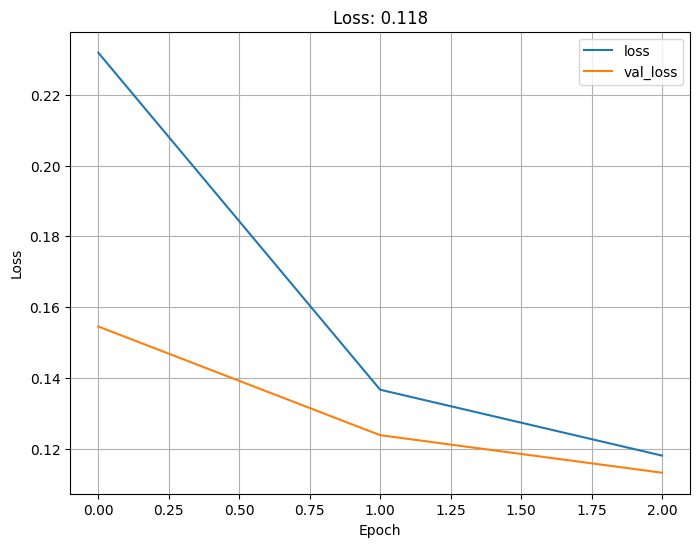

313/313 [==============================] - 0s 1ms/step


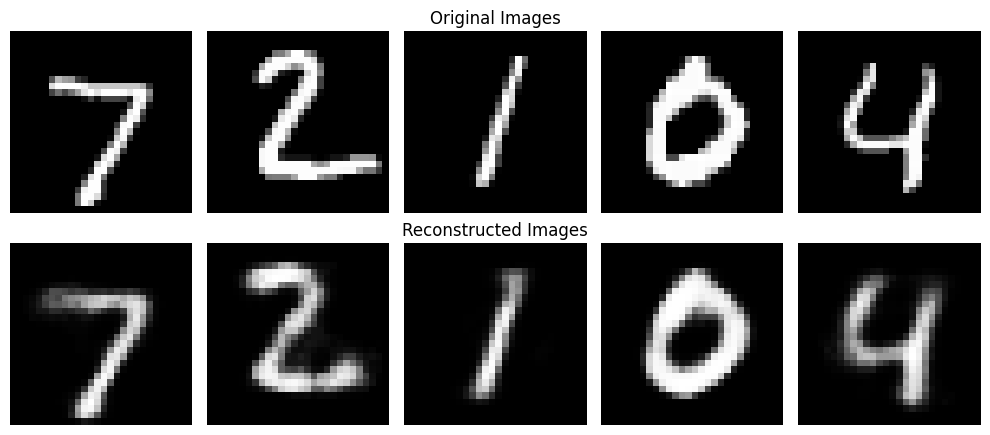

In [8]:
plot_loss(history_deep)
plot_autoencoder_outputs(deep_autoencoder)

## Shallow autoencoder

Uses one dense layer. (Output layer not counted)

In [10]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)
shallow_autoencoder = Model(input_img, output_img)
shallow_autoencoder.compile(optimizer=Adam(),
                            loss='binary_crossentropy')

In [11]:
history_shallow = shallow_autoencoder.fit(x_train, x_train, 
                                          epochs=5, batch_size=256, 
                                          shuffle=True, validation_split=0.1)

Epoch 1/5
211/211 [==============================] - 1s 4ms/step - loss: 0.2866 - val_loss: 0.1972
Epoch 2/5
211/211 [==============================] - 1s 3ms/step - loss: 0.1774 - val_loss: 0.1604
Epoch 3/5
211/211 [==============================] - 1s 3ms/step - loss: 0.1505 - val_loss: 0.1402
Epoch 4/5
211/211 [==============================] - 1s 3ms/step - loss: 0.1334 - val_loss: 0.1261
Epoch 5/5
211/211 [==============================] - 1s 3ms/step - loss: 0.1222 - val_loss: 0.1179


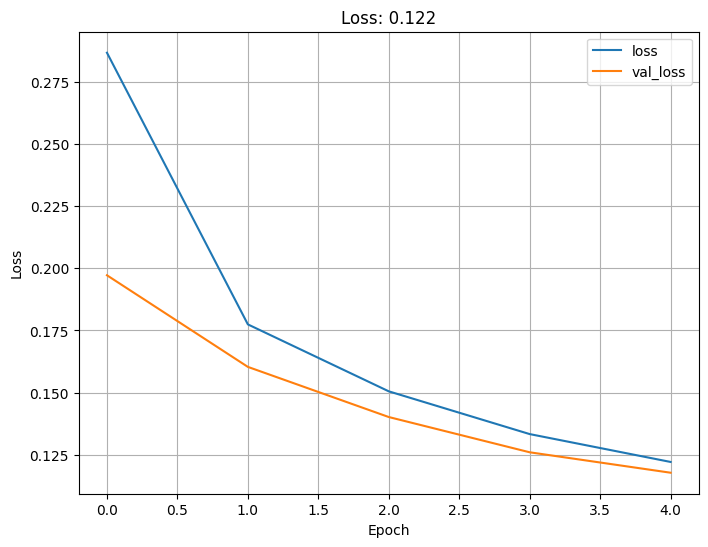

313/313 [==============================] - 0s 944us/step


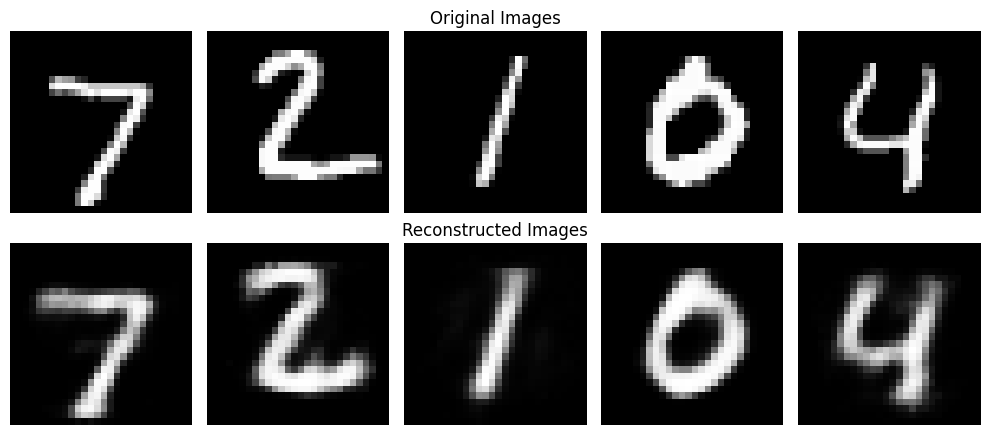

In [12]:
plot_loss(history_shallow)
plot_autoencoder_outputs(shallow_autoencoder)

## Image comparisons

 49/313 [===>..........................] - ETA: 0s

313/313 [==============================] - 0s 995us/step


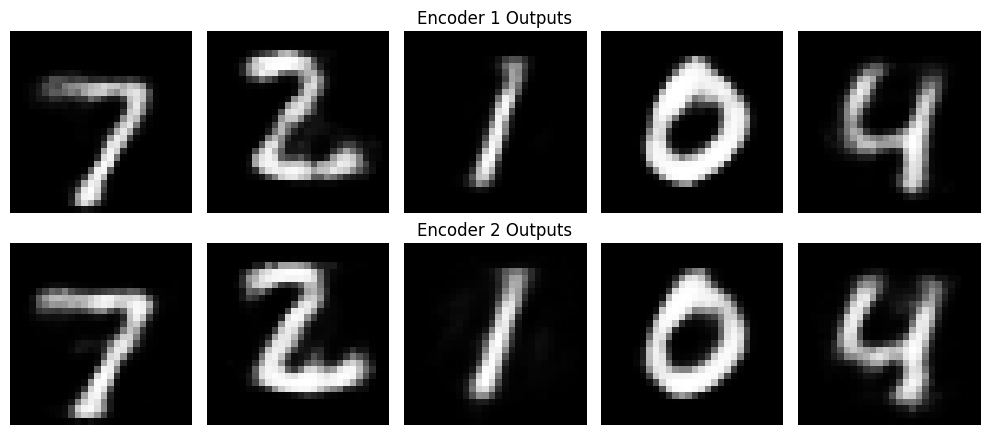

In [14]:
compare_autoencoder_outputs(deep_autoencoder, shallow_autoencoder)

`Encoder 1` is the **Deep autoencoder.**

`Encoder 2` is the **Shallow autoencoder.**